# Can we beat the S&P 500

There's an entire industry devoted to this question. This is an extremely difficult task, and I chose this on purpose because it is. 

The reason this is useful for us is:
* Machine learning doesn't always guarantee results. Sometimes we do the best and we don't come out triumphant. Although you will see that we can probably do better than just holding the market (not assuming trading costs and taxes). 
* The financial markets are really great for showing you how reinforcement learning can be beneficial. The market today will be different tomorrow. For every strategy there is an opposite and equally valid strategy. For instance value vs growth, momentum vs reversal, technical vs non-technical, buy and hold vs volatility capture. It's all valid! So you can't just run a supervised learning model and call it good.

The S&P 500 is usually a good proxy for the "market" at large. It is the top 500 companies picked by Standard and Poors based on Market Capitalization. Market Capitalization is the theoretical price of each company. In simple terms the number of outstanding shares multiplied by the price at that moment. Of course... if AAPL decides to sell all it's stock overnight the price will adjust and it's market cap won't be that... But let's ignore that for now.

According to William Sharpe, Nobel Laureate and Fama and French really this whole exercise is dismal but perhaps we can come up with something better? In machine learning it's always important to try and see what comes out. Even if we can squeeze out an extra basis point (1/10th of a percent) our high net worth clients might pay us graciously for that!

As a disclaimer, because it's important to say this. All of this code is as-is without any warranties. I wouldn't recommend running this against your retirement portfolio with lots of backtesting, testing, and care.

# Forget about CRISP-DM focus on TACT

For my own work I have built my own method which is easier to remember called TACT. It's _very_ similar to CRISP-DM (which you should also look up). It stands for Target, Arrange, Compose, and Transmit.


We will be going through this process in the next two labs

# Target

What is our target? Make as much return as possible? Limit the volatility? Make the best risk adjusted return?

Sharpe Ratio?

Sortino Ratio?

Part of the difficulty with finance is that the optimization is very convex, very stochastic, and many times picking the right objective (or similar loss) is very very important!

If we were going to maximize return most likely we would pick one stock and stick with it, which isn't a great idea. If we were to lower volatility we'd probably just hold cash. Risk adjusted return is about balancing these two concerns and many times shows up in modern portfolio theory called mean variance optimization or MVO for short. 

This effectively tries to limit volatility subject to the return being high enough. That is a great method although really what we're interested in in more specific. We want to beat the S&P 500.

For that there are two major methods:

1. Sharpe ratio which is a measure of return above a risk free return (treasury bonds usually)
2. Sortino ratio. This is a modification of the sharpe ratio that minimizes downside risk of a portfolio
3. Tracking error. This one is subtle. We might want to match the S&P 500 as much as possible while minimizing trading. This shows how well we replicate the S&P 500.

For our exercise we are mostly concerned with can we outperform the S&P 500 over a validation period, and can we accurately predict the next periods return based on an action we take now. That is the real question. 

So we want to be able to measure our ability to execute a trade on Day 1 and estimate what return it will give us in Day 2.

# Arrange

I have taken care of most of the effort of arranging the data. Inside of the data folder is stock data going back from 2000 to 2012. Included in this is the ETF SPY which tracks the S&P 500 well.

Can you create a better sharpe ratio than the S&P 500 over the course of 2008-2012?

In [1]:
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt

from util import create_df_benchmark, get_data
from marketsim import compute_portvals_single_symbol, market_simulator
from strategy import StrategyLearner
from analysis import get_portfolio_value, get_portfolio_stats

In [2]:
train_start_date = dt.datetime(2007, 1, 1)
train_end_date   = dt.datetime(2007, 12, 31)
portfolio_start_date = dt.datetime(2008, 1, 1)
portfolio_end_date = dt.datetime(2008, 12, 31)

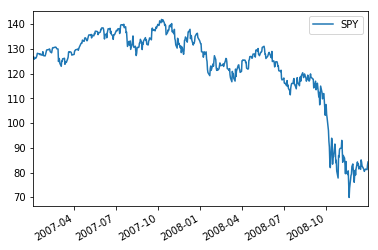

In [3]:
spy_df = get_data(['SPY'], pd.date_range(train_start_date, portfolio_end_date), addSPY=False)

spy_df.plot()

plt.show()

In [4]:
port_val = get_portfolio_value(spy_df[['SPY']], 1.0, 10_000)

# Assuming 3% risk free return compounded over 252 days in a trading year
# Note APR = (1 + r)^252-1 so r = (1+APR)^(1/252) - 1
rfr = (1.03**(1/252.0))-1 

cr, adr, sddr, sr = get_portfolio_stats(port_val, rfr, 252.0)

"Sharpe Ratio over 2008 is: {}".format(sr)

'Sharpe Ratio over 2008 is: -0.5877984069089838'

# Compose the model

For this exercise we will be utilizing a Q-Learning strategy to optimize portfolios over time.

Q-Learning will learn a value Q within a given state given the actions.

So think of it like a table of actions you can take in a given state.

In [5]:
# Let's train up a portfolio given a really tough time market wise

train_start_date = dt.datetime(2007, 1, 1)
train_end_date   = dt.datetime(2007, 12, 31)
portfolio_start_date = dt.datetime(2008, 1, 1)
portfolio_end_date = dt.datetime(2008, 12, 31)

start_val = 100000
symbol = "SPY"
commission = 0.00
impact = 0.0
num_shares = 1000

df_benchmark_trades = create_df_benchmark(symbol, train_start_date, train_end_date, 
                                              num_shares)

1 -0.04359999999999997
2 0.029099999999999904
3 0.19710000000000005
4 0.2248000000000001
5 0.2391000000000001
6 0.2391000000000001
7 0.2391000000000001
8 0.2391000000000001
9 0.2391000000000001
10 0.2391000000000001
11 0.2391000000000001
12 0.2391000000000001
13 0.2391000000000001
14 0.2391000000000001
15 0.2391000000000001
16 0.2391000000000001
17 0.2391000000000001
18 0.2391000000000001
19 0.2391000000000001
20 0.2391000000000001
21 0.2391000000000001


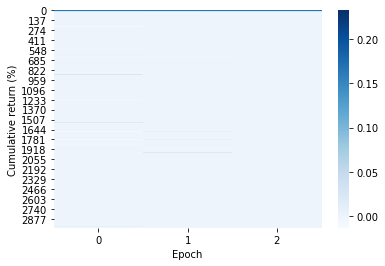

In [6]:
# Train and test a StrategyLearner
# Set verbose to True will print out and plot the cumulative return for each training epoch
from QLearner import QLearner
from IPython.display import clear_output

clear_output()
learner = QLearner(num_states=3000, num_actions=3)
stl = StrategyLearner(num_shares=num_shares, impact=impact, 
                      commission=commission, verbose=True,
                      learner=learner)
stl.add_evidence(symbol=symbol, start_val=start_val, 
                 start_date=train_start_date, end_date=train_end_date)
df_trades = stl.test_policy(symbol=symbol, 
                            start_date=train_start_date,
                            end_date=train_end_date)

Performances during training period for SPY
Date Range: 2007-01-01 00:00:00 to 2007-12-31 00:00:00
Sharpe Ratio of Portfolio: 1.4985301210150006
Sharpe Ratio of Benchmark : 0.4302766380079466

Cumulative Return of Portfolio: 0.2391000000000001
Cumulative Return of Benchmark : 0.0674999999999999

Standard Deviation of Portfolio: 0.010214523079050979
Standard Deviation of Benchmark : 0.012543098253597824

Average Daily Return of Portfolio: 0.0009642359079471759
Average Daily Return of Benchmark : 0.0003399791787050579

Final Portfolio Value: 123910.0
Final Benchmark Value: 106750.0


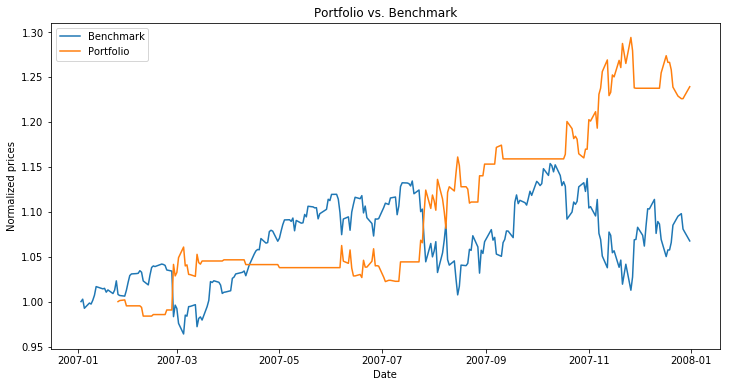

In [7]:
# Retrieve performance stats via a market simulator
print ("Performances during training period for {}".format(symbol))
print ("Date Range: {} to {}".format(train_start_date, train_end_date))
market_simulator(df_trades, df_benchmark_trades, symbol=symbol, 
                 start_val=start_val, commission=commission, impact=impact)


Performances during testing period for SPY
Date Range: 2008-01-01 00:00:00 to 2008-12-31 00:00:00
Sharpe Ratio of Portfolio: 0.379729581955997
Sharpe Ratio of Benchmark : -0.6803344241208477

Cumulative Return of Portfolio: 0.07160000000000011
Cumulative Return of Benchmark : -0.4789

Standard Deviation of Portfolio: 0.022505375160566953
Standard Deviation of Benchmark : 0.04099177880652898

Average Daily Return of Portfolio: 0.00053834467017274
Average Daily Return of Benchmark : -0.0017567863182126715

Final Portfolio Value: 107160.0
Final Benchmark Value: 52110.0


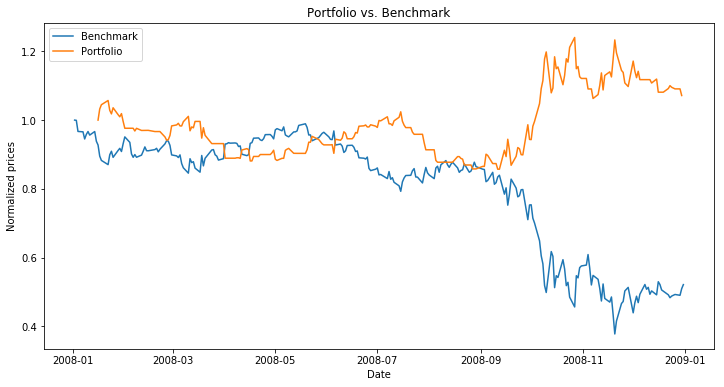

In [10]:
df_benchmark_trades = create_df_benchmark(symbol, portfolio_start_date, portfolio_end_date, 
                                          num_shares)

df_trades = stl.test_policy(symbol=symbol, start_date=portfolio_start_date, 
                            end_date=portfolio_end_date)
print ("\nPerformances during testing period for {}".format(symbol))
print ("Date Range: {} to {}".format(portfolio_start_date, portfolio_end_date))
market_simulator(df_trades, df_benchmark_trades, symbol=symbol, 
                 start_val=start_val, commission=commission, impact=impact)